# Introduction to LAMMPS
Guido Raos, Politecnico di Milano, April 2020 (guido.raos@polimi.it)

LAMMPS stands for "Large-scale Atomic/Molecular Massively Parallel Simulator". It is a powerful, open-source code for Molecular Dynamics (MD) simulations. It is maintained and distributed by the Sandia National Laboratories, in the USA: https://lammps.sandia.gov/

Take your time to browse through the LAMMPS web site. Start from the "Pictures" and "Movies" sections: hopefully this will stimulate your appetite for MD simulations. Afterwards, take a look also at the other sections.

Link to the on-line **MANUAL**: https://lammps.sandia.gov/doc/Manual.html. Notes:
* LAMMPS is very powerful, and as a result the manual is very large (the pdf version is > 2000 pages!). It can be daunting on first approach, but don't be scared! We will start from the simplest, most basic features.
* The on-line version of the manual documents the latest version of the code, which might not coincide with the version installed on your computer. A pdf version on the manual corresponding to your LAMMPS version is available inside the "Doc" subdirectory of the installation, on your computer.

Once you have become familiar with the general structure of LAMMPS inputs, you may also use **Google**. For example, searching "LAMMPS fix NVT" should lead directly to the relevant page of the manual.

There is also a useful **TUTORIAL** section, for beginners:  https://lammps.sandia.gov/tutorials.html

## LAMMPS Installation

Download the pre-built executable code for your platform (Windows, Mac or Linux) from here:  https://lammps.sandia.gov/download.html
Follow the installation instructions. If everything has gone well, you should be able to run LAMMPS from the command line, like this:
```
%> lmp_serial
```
(the program will complain that there is no input: don't worry about it!). Make a note of the directory on the computer where LAMMPS has been installed. In my case it is  `C:\Program Files\LAMMPS 64-bit 7Dec2018`. This will contain a few sub-directories:
* `bin` for the (binary) executables. Your computer's `PATH` variable should point to this directory;
* `Doc` for the documentation (manuals);
* `Examples` and `Benchmarks` for input/output examples (the benchmarks are computationally demanding examples);
* `Potentials` and `frc_files` for files with parameters for interatomic potentials and force fields.

Note that the full LAMMPS distribution, which includes the source code, has some additional directories. You might want to download and compile it later. The pre-built version of the code does not include all the features described on the manual, but only a selection of the most popular ones. 

## Using LAMMPS

To run LAMMPS, giving it an input and an output file:
```
%> lmp_serial -in in.file -log log.file
```
This will also printout information on the screen. For long jobs (lasting hours or days), it is convenient to redirect the screen printout to another file and, in addition, to run the job "in the background" (use `W%>` for Windows and `U%>` for Unix-like Linux/Mac):
```
W%> start /B lmp_serial -in in.file -log log.file > screen.file
U%> lmp_serial -in in.file -log log.file > screen.file &
```

## LAMMPS minimization of LJ clusters

In addition to performing MD simulations, LAMMPS can also do energy minimizations. Here we use it to replicate (with some important differences) the minimization of the Lennard-Jones cluster from the previous practical. This is a starting input file (to be copied inside "LJ_minimize.inp"):

```
# Preliminary definitions
units		  lj
boundary	  f f f
atom_style	  atomic

# Define a lattice, which can be used by following commands
lattice		  fcc 1.0

# Define two spherical regions centered on origin
region		  ball1  sphere 0.0 0.0 0.0  1.2   units box
region        ball2  sphere 0.0 0.0 0.0  7.0   units box
create_box	  1   ball2

# Create atoms within the smaller box
create_atoms  1   region ball1    #  basis   units lattice
#create_atoms  1   random  13 239811    ball1

# Define properties and interactions among the atoms
mass          1   1.0
# Atoms interact by LJ potential with cutoff at r=3.0
pair_style lj/cut  3.0
# Supply parameters for LJ Interactions between type_1-type_1 atoms
pair_coeff 1 1  1.0  1.0  # epsilon sigma
#pair_modify tail no

# Define the type and amount of output
thermo 3
thermo_modify lost warn
dump          1  all xyz 3 LJ_minimize.xyz 

# Run an energy minimization 
min_style  sd   # cg
minimize   1.0e-6 1.0e-8 1000 10000     #etol ftol maxiter maxeval

```

LAMMPS executes by reading commands from a input script (text file), one line at a time. When the input script ends, LAMMPS exits. Some commands may require other commands before them.
See here:  https://lammps.sandia.gov/doc/Commands_category.html


## MD simulation of Argon (NVE)

Here is a simple LAMMPS input for our first MD simulation.

```
# Preliminary definitions
units		   real    # real units (not LJ!)
boundary	   p p p   # 3D periodic boundary conditions
atom_style	   atomic

# Define a lattice, which can be used by following commands
# the "lattice" parameter has a different meaning in LJ and real units (see manual)
lattice		   fcc 6.0

# Define a "box" and fill it with atoms
region		   box1  block 0.1 8.1 0.1 8.1 0.1 8.1  # Distances are in lattice units
create_box	   1 box1
create_atoms   1 box

# The atoms are actually Argon, with the following parameters
mass           1  39.948002
pair_style     lj/cut 10.0
pair_coeff     1 1  0.2379  3.405
pair_modify    tail yes

# Define the type and amount of output
thermo         25
dump           dumpID  all  atom/gz  100  LJ_dynamics.lammpstrj.gz
#dump           dumpID  all  xyz  100  LJ_dynamics.xyz

# Run the MD simulation (NVE)
timestep       2
fix            1  all  nve
run		       10000
```

Look carefully at the input. Note that:
1.  One important difference between this and the previous calculation is that here were are effectively simulating "bulk" system, instead of a discrete cluster. This is possible thanks to the use of the "three-dimensional periodic boundary conditions":  https://lammps.sandia.gov/doc/boundary.html
2. We are using "real" units, instead of Lennard-Jones units:  https://lammps.sandia.gov/doc/units.html
3. Since we are using "real" units, we must specify "real" values for the properties of the atoms which we are simulating. We are using the parameters appropriate for Argon.
4. The trajectories (i.e., atomic coordinates and other information) generated during an MD simulation can be stored or "dumped" to a file in a variety of different formats: https://lammps.sandia.gov/doc/dump.html. The ```*.lammpstrj``` file can be visualized with VMD, like an ```*.xyz```. But, in order to do so, the ```*.lammpstrj.gz``` must be decompressed first:
```
%> gzip -d LJ_dynamics.lammpstrj.gz
```
5. The number of timesteps which are simulated is determined by the last line of the input (```run 10000```). Each timestep corresponds to 2.0 fs (```timestep 2```). A very important line, which determines how the system evolves during each timestep, is the one in between (```fix 1 all nve```).  In LAMMPS, a “fix” is any operation that is applied to the system during timestepping or minimization. Examples include updating of atom positions and velocities due to time integration, controlling temperature, applying constraint forces to atoms, enforcing boundary conditions, computing diagnostics, etc. There are hundreds of fixes defined in LAMMPS and new ones can be added. See here: https://lammps.sandia.gov/doc/fix.html. **The fix command is very important within LAMMPS.** Try to read it carefully and understand it. You may need to go back and re-read it after some time, as your understanding of LAMMPS and MD simulations increase.

Copy the previous LAMMPS code inside an input file (e.g., "LJ_dynamics.inp") and then run the simulation. It should take less than 1 minute. Look at the output file with a text editor and visualize the ```*.lammpstrj``` with VMD.

It can be useful to plot the thermodynamic information (e.g., temperature, potential energy and total energy) from the ```*.log```  file. To do it, copy it into a separate file:
```
W%> copy LJ_dynamics.log thermo.dat
U%> cp LJ_dynamics.log thermo.dat
```
Open the ```*.dat``` file with a text editor and delete all the lines before and after those with the thermodynamic information. Close the file and plot it as follows (change the columns numbers to plot different things).

Text(0, 0.5, 'Temperature')

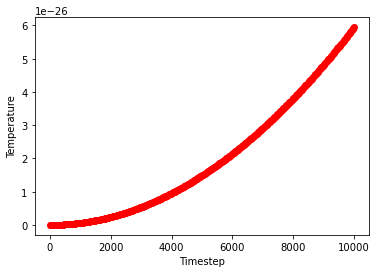

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The data in each column are, respectively:  Step Temp E_pair E_mol TotEng Press 
data = np.loadtxt('thermo.dat', skiprows=1)
#print(data)
plt.plot(data[:,0], data[:,1], 'r-o')
plt.xlabel('Timestep')
plt.ylabel('Temperature')

Note that the temperature is very small. Why? What does this mean? Plot also the other quantities.

**Hint:** according to statistical mechanics, "temperature" is a measure of the atoms' average kinetic energy.
We have used a ```fix 1 all nve``` command, according to which the their coordinates evolve according to Newton's equation of motion. These keep the number of particles (N), the volume (V) and total Energy (E) constant. This is the so-called "NVE esemble".
Notice that we did not initialize the atoms' velocities. LAMMPS therefore assumed that they are all zero in the first timestep.
To initialize the atoms' velocities with values consistent with a certain temperature (e.g., T=298 K), see here: https://lammps.sandia.gov/doc/velocity.html.

## <font color=blue> Tasks <font>

Questions and suggestions for further work:
* read the LAMMPS documentation and see how to initialize the atoms' velocities, for a given temperature.
* does the average temperature in the output correspond to the one in the input? If not, is it higher or lower? Why?
* how does the total potential energy (sum of all pairwise LJ interactions) change over the course of a simulation? Why?
* re-run the simulation with different time steps. Which is the largest value of the time step which, for a given temperature, ensures that the total energy is actually conserved? [Note. The energy will not be conserved in the first steps, even with a small timestep.]


## MD Simulation of Argon (NVT)

We shall now perform a more elaborate simulation. We want to perform an MD simulation of the liquid at the experimental triple point temperature and density: https://lar.bnl.gov/properties/.

Our aim is to compute the pressure and the Ar-Ar pair distribution function, and compare it to experiment. These comparisons will allow us to judge the quality of the Lennard-Jones potential used to model Argon. We also want to use the simulations to test the equipartition theorem Maxwell-Boltzmann distribution for the velocities.

The simulations are performed in the NVT ensemble. The system's energy is no longer contant, as we imagine that it is in "contact" with a thermostat at a temperature $T$. To model the exchange of energy with this (fictitious) heat bath, we modify Newton's equations of motion by adding to the conservative forces ($-\nabla_i V$) a frictional (drag) force and a stochastic (random) force:
\begin{equation}
m_i \ddot{\mathbf{r}}_i = - \nabla_i V({\mathbf{r}_1,...,\mathbf{r}_N}) - \zeta_i\dot{\mathbf{r}}_i + \mathbf{X}_i(t) \, .
\end{equation}
This approach is known as [Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics). It is usually employed to model the [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) of colloidal particles but, with the right set of parameters, it can be used also to describe the "almost Newtonian" dynamics of the individual atoms within an NVT MD simulation.
In the Langevin equation, the term $\mathbf{X}_i(t)$ represents a random force, whose fluctuations obey the following statistical properties:
\begin{eqnarray*}
\left\langle X_{i,\alpha}(t) \right\rangle &=& 0 \hspace{1cm} (\alpha, \beta=x,y,z) \\
\left\langle X_{i,\alpha}(t) X_{j,\beta}(t') \right\rangle &=& 2 \zeta_i k_BT \delta_{ij}\delta_{\alpha \beta} \delta(t-t') \, .
\end{eqnarray*}
The first equation simply says that the average components of the force should be zero. The second equation says that there should be no correlation between different components of the force ($\delta_{\alpha \beta}$), no correlation between its values at different particles ($\delta_{ij}$), no correlation between its values at different times [$\delta(t-t')$]. Finally, the mean-square value of the force should be proportional to the absolute temperature $T$ and to the friction coefficient $\zeta_i$, which appears within the drag term of the Langevin equation. It could be shown that, if these conditions are satisfied, the average kinetic energy of the particle satisfies the equipartition theorem for the target temperature (i.e., the system is thermostatted correctly):
\begin{equation*}
\frac{1}{2} m_i \left\langle \dot{\mathbf{r}}_i^2 \right\rangle = \frac{3}{2}k_BT \, .
\end{equation*}
This happens independently of the value of the $\zeta_i$ parameters. If $i$ was indeed a large Brownian particle, a resonable value of its friction coefficient would be given by Stokes' law:
\begin{equation*}
\zeta_i = 6 \pi \eta a_i
\end{equation*}
where $\eta$ is the shear viscosity of the surrounding medium and $a_i$ is the radius of the particle. In the case of an MD simulation, instead, a typical criterion is that the "damping parameter" should be of the order of 100 timesteps (see here for further details https://lammps.sandia.gov/doc/fix_langevin.html). 

The following input also allows us to introduce several new features of LAMMPS. Read it carefully and try understand what it is doing, looking for the appropriate commands in the LAMMPS manual.

```
# Preliminary definitions
units           real    # real units (not LJ!)
boundary        p p p   # 3D periodic boundary conditions
atom_style      atomic

# Number of atoms to be simulated
variable        N equal 5000

# Compute the box size to accomodate those atoms, using exp. data for Argon at triple point
# https://lar.bnl.gov/properties/
variable        NAv equal 6.02214*10^23   # 1/mol
variable        M equal 39.948002         # g/mol
variable        T equal 83.8              # K
variable        P equal 0.68891/1.01325   # atm
variable        D equal 1.417             # g/cm^3
# Variables can be used to define other variables (do not use spaces in formulae!)
variable        V equal v_N*v_M/v_D/v_NAv # cm^3
print           "Cell Volume (cm^3) = $V"
variable        L equal v_V^(1./3.)*10^8
print           "Cell Lengths (Angs)= $L"

# Define a lattice, which can be used by following commands
# the "lattice" parameter has a different meaning in LJ and real units (see manual)
lattice         fcc 6.0

# Define a "box" and fill it with atoms
region           box1  block 0.0 $L 0.0 $L 0.0 $L units box   # Distances are in Angstroms
create_box       1 box1
create_atoms     1 random  $N  9118281   box1

# The atoms are actually Argon, with the following parameters
mass             1  ${M}
pair_style       lj/cut 10.0
pair_coeff       1 1  0.2379  3.405   # epsilon sigma
pair_modify      tail yes

# Define the type and amount of thermodynamic output to screen
variable       Pred equal v_thermo_press/v_P
thermo_style   custom step vol density temp pe ke etotal press       # v_Pred
thermo         50

# Run a quick energy minimization from initial configuration, before the MD 
min_style      sd   # cg
minimize       1.0e-3 1.0e-4 1000 10000     #etol ftol maxiter maxeval

# Before running MD, define file for dumping coordinates
dump           dumpID  all  custom/gz  250  LJ_Langevin.lammpstrj.gz &
                       id type mass x y z vx vy vz 

# example of LAMMPS "compute" command:
# extract and print the radial distribution function
compute         arrdf  all  rdf  200
fix             outrdf all ave/time 25 10 250 &
                       c_arrdf[*] file ar_rdf.dat mode vector

# Set initial velocity
velocity       all create $T 9861515
write_data     LJ_Langevin.data

# Run the MD simulation (NVT with Langevin thermostat)
timestep       4
fix            1  all langevin $T $T 400 1971621
fix            2  all nve
run            50000
```


## <font color=blue> Futher tasks <font>

Here are a few suggestions:
* compute the pressure from the thermodynamic output, by averaging over many (many!) time steps, and estimate the error in the average value (see previous notebook on "data analysis". [Note 1. Don't be scared if the pressure appears to fluctuate wildly. Note 2. The estimate of the "standard error" is based on the assumption that successive values of the pressure are statistically independent. This may or may not be the case, depending also on the chosen frequency for writing out the thermodynamic information.]
* compute and plot the Ar-Ar radial distribution function $g(r)$, using either VMD or the LAMMPS code (see above, the part which writes the "ar_rdf.dat" file).
* repeat the calculation of pressure and $g(r)$ at different densities and/or temperatures. How do they change?
* the dump file ("LJ_Langevin.lammpstrj") contains, in addition to the atomic coordinates, also their velocities. Use these velocities to check whether the Maxwell-Boltzmann distribution is obeyed.

## <font color=blue> Even further tasks <font>

If you are bold and interested enough, you may expore LAMMPS' `Examples` and `Benchmarks` directories and look for ideas for "computational projects" that could be developed. For example:

* A popular coarse-grained model for polymer chains is the one proposed by [Kremer and Grest]( https://doi.org/10.1063/1.458541) in the 1990's. It is a bead-and-spring model, where the "beads" interact by purely repulsive WCA potentials and the "springs" connecting them are represented by non-linear [FENE](https://lammps.sandia.gov/doc/bond_fene.html) bonds. Variants of the model have been  to simulate entanglements in polymer melts, rubber networks, nanocomposites, polymers in thin films, polymer glasses, etc.. See also [this article](https://arxiv.org/abs/1808.03509) for its adapatation to model specific commodity polymers. Find out how to use it in LAMMPS to model polymer melts of different lengths, and extract some interesting quantities (e.g., the chains' diffusion coefficients and radii of gyration). An executable distributed with LAMMPS ([chain.exe](https://lammps.sandia.gov/doc/Tools.html#chain)) can be used to generate reasonable initial "random coil" configurations for the chains.

* The [Embedded-Atom Model](https://lammps.sandia.gov/doc/pair_eam.html) (EAM) can be used to simulate metals, both in the solid state (with non-directional bonding forces, as in those FFC/CCP structures) and in the liquid state. Look for the EAM parameter files for a element of your choice, find out how to them within LAMMPS and perform simulations with it. See also https://openkim.org/ and https://www.ctcms.nist.gov/potentials/, to find out which potentials are available for which elements.

* Due to lack of time we could not illustrate the use of "many-body" and "reactive" force fields. A prototype of such force fields is the Stillinger-Weber potential, which was originally developed in the 1980's to perform MD simulations of solid and liquid Silicon.
See here: https://www.ctcms.nist.gov/potentials/entry/1985--Stillinger-F-H-Weber-T-A--Si/ and the LAMMPS documentation https://lammps.sandia.gov/doc/pair_sw.html. Later, the same potential was re-parametrized to model also other elements (e.g. Carbon) and even water (see [Water Modeled As an Intermediate Element between Carbon and Silicon](https://pubs.acs.org/doi/10.1021/jp805227c)). This is a link to another molecular modeling course, which contains an "exercise" for the students invoving the SW potential (using another program): http://www.pages.drexel.edu/~cfa22/msim/node41.html. See also the `Examples/threebody` directory.


Please don't be afraid to ask for explanations or to suggest other topics.

## Final recommendation

LAMMPS is a powerful and complex code, with many fancy features. However, it can also be frustrating to use for a novice. It takes time to appreciate how it works. Each input file is like a computer program, which should be tested and debugged. If you are trying to write your own LAMMPS input, do *not* do it all in one go. Start by writing a few lines, and run LAMMPS for a few time steps to test them. Look carefully at the output. Visualize also the trajectory with VMD or another visualization program. Correct your input, if the program does not behave as expected. Add a few more lines, and test them. And so on and so forth, until the program is complete. Only then, after you are sure that it is also correct, run the full simulation. Be patient, and enjoy!